In [33]:
import pandas as pd
import numpy as np
import matplotlib as mpt
mpt.rcParams['xtick.labelsize'] = 12
mpt.rcParams['ytick.labelsize'] = 12
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sys
import pystan
import scipy
from ggplot import *
import math
import re
import json
from datetime import datetime
%matplotlib inline
from pandas.io.json import json_normalize
pd.options.mode.chained_assignment = None 

# Employment

In [34]:

employment_json = pd.read_json("https://data.ssb.no/api/v0/dataset/1054.json?lang=en")

age_labels = employment_json["dataset"]["dimension"]["Alder"]
sex_labels = employment_json["dataset"]["dimension"]["Kjonn"]
content_labels = employment_json["dataset"]["dimension"]["ContentsCode"]


In [35]:
employment = pd.read_csv("https://data.ssb.no/api/v0/dataset/1054.csv?lang=en")

employment.columns = ["sex", "age", "contents", "time", "value"]

unemp_1000 = employment[employment.contents == 'Unemployment (LFS) (1 000 persons), seasonally adjusted']
#unemp_1000 = unemp_1000[unemp_1000.sex=="0 Both sexes"]
unemp_1000 = unemp_1000[unemp_1000.age=="25-74 25-74 years"]
unemp_1000 = unemp_1000[["time", "sex", "value"]]

unemp_1000["time"] = unemp_1000.time.apply(lambda x:  x.replace("M", ""))
unemp_1000["time"] = pd.to_datetime(unemp_1000["time"], format="%Y%m")

unemp_1000["value"][unemp_1000.value == ".."] = np.nan
unemp_1000["value"] = unemp_1000.value.astype(float)

unemp_1000.columns =["date", "sex", "value"]
unemp_1000["sex"] = unemp_1000.sex.apply(lambda x: x[2:])


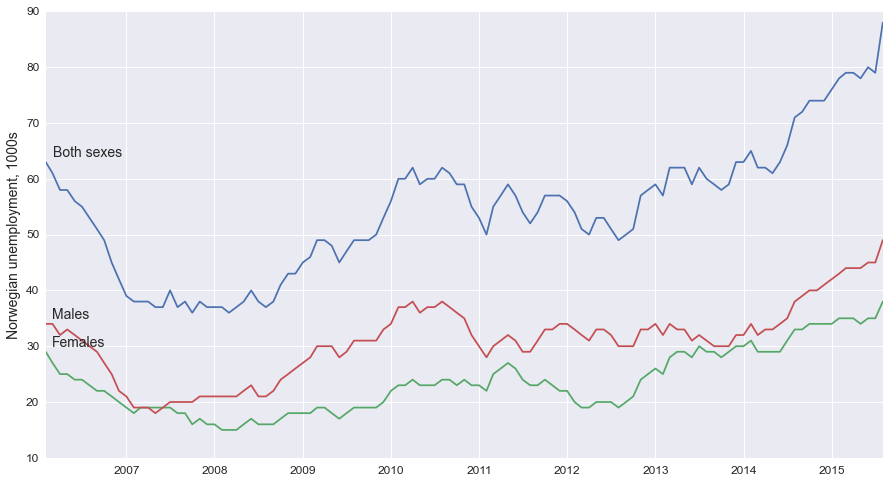

In [36]:
fig, ax = plt.subplots()
start = datetime.strptime('01032006', '%d%m%Y')
unemp_by_sex = unemp_1000.groupby("sex")
for unemp in unemp_by_sex:
	ax.plot(unemp[1].date, unemp[1].value, label=unemp[0])
	ax.annotate(unemp[0], xy=(start, np.array(unemp[1].value)[0]+1), size=14)
ax.set_ylabel("Norwegian unemployment, 1000s", size=14)
fig.set_size_inches(15,8)
fig.savefig("figures/unemployment.png", bbox_inches='tight')
plt.show()

In [37]:
emp_perc_sa = employment[employment.contents == "Employed persons in per cent of the population, seasonally adjusted"].copy()
emp_perc_sa.is_copy = False

emp_perc_sa = emp_perc_sa[emp_perc_sa.age=="25-74 25-74 years"]
emp_perc_sa = emp_perc_sa[["time", "sex", "value"]]

emp_perc_sa.loc[:,"time"] = emp_perc_sa.time.apply(lambda x:  x.replace("M", ""))
emp_perc_sa.loc[:,"time"] = pd.to_datetime(emp_perc_sa["time"], format="%Y%m")

emp_perc_sa.loc[:,"value"][emp_perc_sa.value == ".."] =np.nan
emp_perc_sa.loc[:,"value"] = emp_perc_sa.value.astype(float)

emp_perc_sa.columns =["date", "sex", "value"]
emp_perc_sa.loc[:,"sex"] = emp_perc_sa.sex.apply(lambda x: x[2:])

emp_perc_sa.set_index("date", inplace=True)
emp_perc_sa.reset_index(inplace=True)

start = datetime.strptime('01012008', '%d%m%Y')



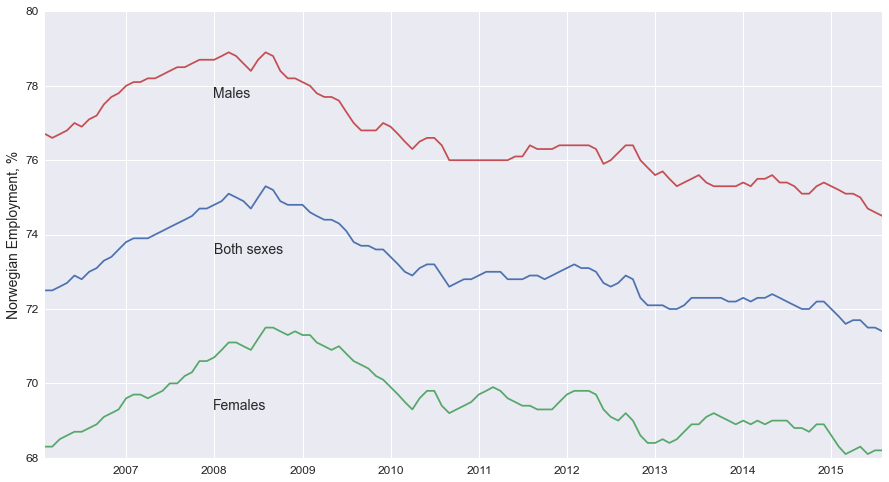

In [38]:
fig, ax = plt.subplots()
emp_by_sex = emp_perc_sa.groupby("sex")
for emp in emp_by_sex:
	ax.plot(emp[1].date, emp[1].value, label=emp[0])
	ax.annotate(emp[0], xy=(start, np.array(emp[1].value)[0]+1), size=14)
ax.set_ylabel("Norwegian Employment, %", size=14)
fig.set_size_inches(15,8)
fig.savefig("figures/employment.png", bbox_inches='tight')
plt.show()

In [39]:
bankruptcies = pd.read_csv("https://data.ssb.no/api/v0/dataset/95265.csv?lang=en")

enter_bank = bankruptcies[bankruptcies.contents == 'Bankruptcies related to enterprises (excl. sole propriertorships)']
pers_bank = bankruptcies[bankruptcies.contents == 'Personal bankruptcies (incl. sole propriertorships)']

def format_df(df):
	df.columns = ["time", "contents", "value"]
	df = df[["time", "value"]]
	df.loc[:, "time"] = df.time.apply(lambda x:  x.replace("M", ""))
	df.loc[:, "time"] = pd.to_datetime(df["time"], format="%Y%m")
	df.loc[:, "value"][df.value == ".."] =np.nan
	df.loc[:, "value"] = df.value.astype(float)
	return(df)

enter_bank = format_df(enter_bank)
pers_bank = format_df(pers_bank)

start = datetime.strptime('01012000', '%d%m%Y')




In [40]:
from scipy.interpolate import UnivariateSpline

enter_bank = enter_bank[enter_bank.value.notnull()]
pers_bank = pers_bank[pers_bank.value.notnull()]

t = len(enter_bank.time)
T = [i for i in range(t)]
s_enter = UnivariateSpline(T, enter_bank.value, k=3, s=400000)
smooth_enter = s_enter(T)
s_pers = UnivariateSpline(T, pers_bank.value, k=3, s=200000)
smooth_person = s_pers(T)

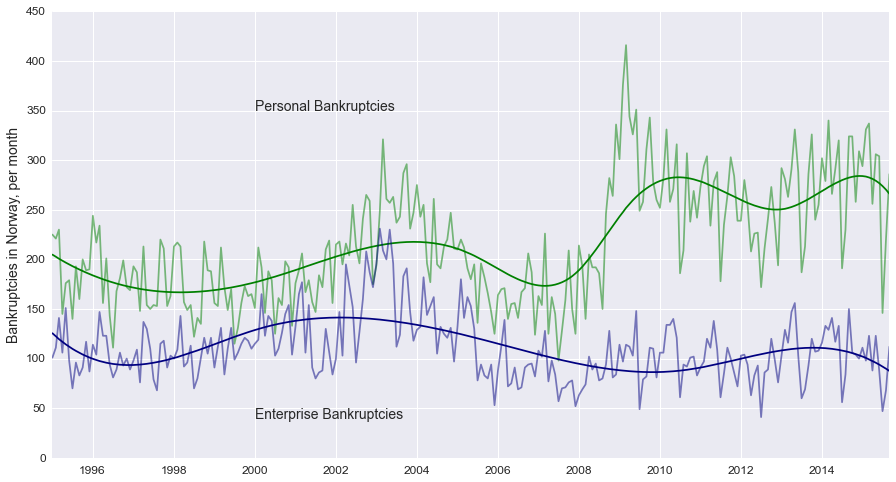

In [41]:
fig, ax = plt.subplots()
ax.plot(enter_bank.time, enter_bank.value, color="green", alpha=.5)
ax.plot(enter_bank.time, smooth_enter, color="green")
ax.plot(pers_bank.time, pers_bank.value, color="navy", alpha=.5)
ax.plot(pers_bank.time, smooth_person, color="navy")
ax.annotate('Personal Bankruptcies', xy=(start, 350), size=14)
ax.annotate('Enterprise Bankruptcies', xy=(start, 40), size=14)
ax.set_ylabel("Bankruptcies in Norway, per month", size=14)
fig.set_size_inches(15,8)
fig.savefig("figures/bank_plot.png", bbox_inches='tight')
plt.show()

# Housing Prices

In [42]:
house_prices = pd.read_csv("https://data.ssb.no/api/v0/dataset/1060.csv?lang=no", sep=";", header=0)
house_prices.columns = ['region', 'type', 'time', 'variable','value']
time = house_prices.time.apply(lambda x: x.replace("K",""))
month = [str(int(t[-1])*3) for t in time]
year = [str(int(t[:-1])) for t in time]
house_prices["time"] = [x+y for x,y in zip(year, month)]
house_prices["time"] = pd.to_datetime(house_prices.time, format='%Y%m')
na_values = ["..", "."]
house_prices = house_prices[~house_prices.value.isin(na_values)]
house_prices["value"] = house_prices.value.apply(lambda x: float(x.replace(",", ".")))

all_houses = house_prices[house_prices.type=="00 Boliger i alt"]

start = datetime.strptime('01012005', '%d%m%Y')
end = datetime.strptime('01012015', '%d%m%Y')
all_houses = all_houses[all_houses.time>=start]


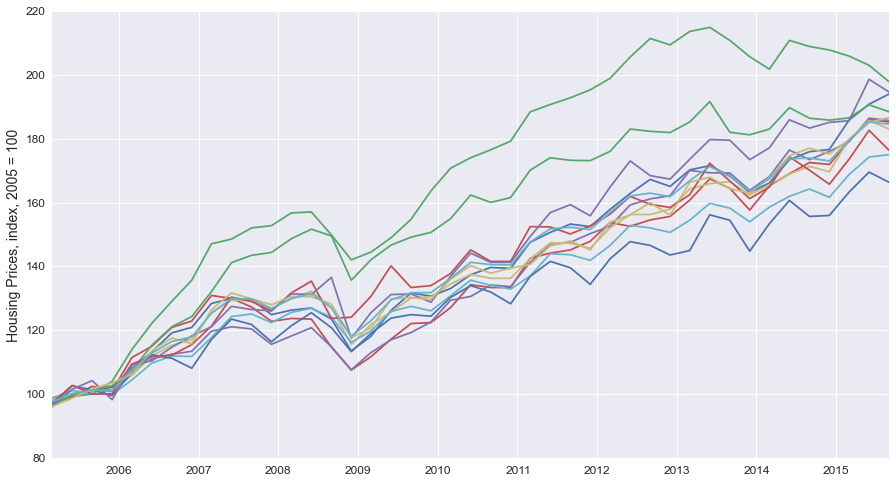

In [43]:
fig, ax = plt.subplots()
houses_by_region= all_houses.groupby("region")
for region in houses_by_region:
	ax.plot(region[1].time, region[1].value, label=region[0])
	#ax.legend()
	#n = len(region[1].value)
	#ax.annotate(region[0], xy=(end, region[1].value[0]) )
ax.set_ylabel("Housing Prices, index, 2005 = 100", size=14)
fig.set_size_inches(15,8)
fig.savefig("figures/housing_prices.png", bbox_inches='tight')
plt.show()

In [44]:
names = []
prices_by_region = house_prices.groupby("region")
for region in prices_by_region:
	names.append(region[0])

new_names = ["Oslo with Baerum", "Stavanger", "Bergen", 
"Trondheim", "Akershus", "Southeast", "Hedmark and Oppland",
"Agder and Rogaland", "Westcoast", "Troendelag", "Northern Norway",
"Total"]

names_dict = dict(zip(names,new_names))

house_prices["region"] = house_prices.region.apply(lambda x: names_dict[x])

cities = new_names[0:4]

house_prices_cities = house_prices[house_prices.region.isin(cities)]
total_cities = house_prices_cities[house_prices_cities.type == "00 Boliger i alt"]


In [45]:
start = datetime.strptime('01012005', '%d%m%Y')
end = datetime.strptime('01012015', '%d%m%Y')
total_cities = total_cities[total_cities.time>=start]


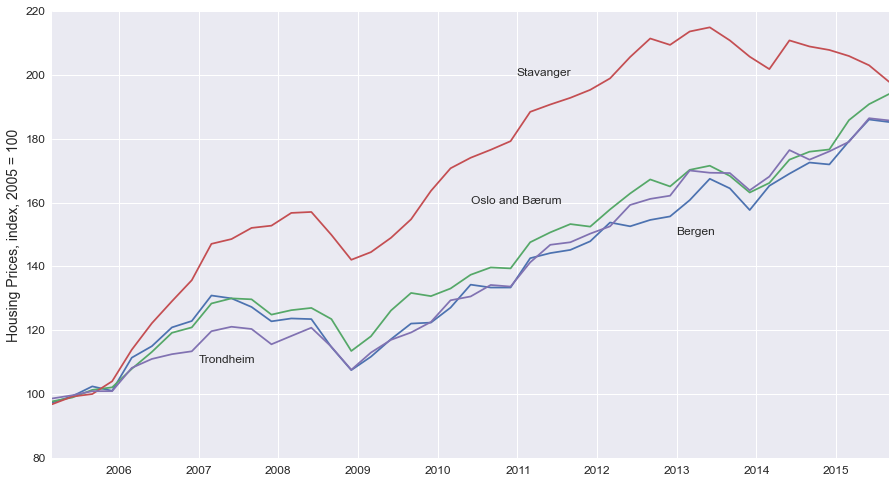

In [46]:
fig, ax = plt.subplots()
houses_by_city= total_cities.groupby("region")
for city in houses_by_city:
	ax.plot(city[1].time, city[1].value, label=city[0])
	#ax.legend()
	#n = len(region[1].value)
ax.annotate("Trondheim", xy=(datetime.strptime('01012007', '%d%m%Y'),110), size=12)
ax.annotate("Bergen", xy=(datetime.strptime('01012013', '%d%m%Y'),150), size=12)
ax.annotate("Stavanger", xy=(datetime.strptime('01012011', '%d%m%Y'),200), size=12)
ax.annotate("Oslo and Bærum", xy=(datetime.strptime('01062010', '%d%m%Y'),160), size=12)

ax.set_ylabel("Housing Prices, index, 2005 = 100", size=14)
fig.set_size_inches(15,8)
fig.savefig("figures/city_housing_prices.png", bbox_inches='tight')
plt.show()